# Assignment overview <ignore>
The overarching goal of this assignment is to produce a research report in which you implement, analyse, and discuss various Neural Network techniques. You will be guided through the process of producing this report, which will provide you with experience in report writing that will be useful in any research project you might be involved in later in life.

All of your report, including code and Markdown/text, ***must*** be written up in ***this*** notebook. This is not typical for research, but is solely for the purpose of this assignment. Please make sure you change the title of this file so that XXXXXX is replaced by your candidate number. You can use code cells to write code to implement, train, test, and analyse your NNs, as well as to generate figures to plot data and the results of your experiments. You can use Markdown/text cells to describe and discuss the modelling choices you make, the methods you use, and the experiments you conduct. So that we can mark your reports with greater consistency, please ***do not***:

* rearrange the sequence of cells in this notebook.
* delete any cells, including the ones explaining what you need to do.

If you want to add more code cells, for example to help organise the figures you want to show, then please add them directly after the code cells that have already been provided. 

Please provide verbose comments throughout your code so that it is easy for us to interpret what you are attempting to achieve with your code. Long comments are useful at the beginning of a block of code. Short comments, e.g. to explain the purpose of a new variable, or one of several steps in some analyses, are useful on every few lines of code, if not on every line. Please do not use the code cells for writing extensive sentences/paragraphs that should instead be in the Markdown/text cells.

# Abstract/Introduction (instructions) - 15 MARKS <ignore>
Use the next Markdown/text cell to write a short introduction to your report. This should include:
* a brief description of the topic (image classification) and of the dataset being used (CIFAR10 dataset). (2 MARKS)
* a brief description of how the CIFAR10 dataset has aided the development of neural network techniques, with examples. (3 MARKS)
* a descriptive overview of what the goal of your report is, including what you investigated. (5 MARKS)
* a summary of your major findings. (3 MARKS)
* two or more relevant references. (2 MARKS)

This report examines the performance of various CNN models in an image classification task on the CIFAR-10 dataset. CIFAR-10 contains 60,000 32x32 color images each depicting an object or animal that belongs to one of 10 non-overlapping classes, with 6000 images per class. (Abouelnaga et al., 2016)

At the time of its creation image datasets with reliable class labels were not available, making it difficult to do object recognition experiments (Krizhevsky & Hinton, 2009). Because of this, CIFAR-10 has been instrumental in advancing image recognition, serving as a benchmark for performance evaluation, and has fostered the development of CNNs including influential architectures like AlexNet (created by and named after the author of CIFAR-10). 

The goal of this report is to investigate the effect of choices of hyperparameters and other techniques on the effective training of a CNN on an image classification task using CIFAR-10. This includes the comparison of the model's performance across learning rates and dropout rates, as well as the effectiveness of techniques such as learning rate scheduling, transfer learning, and batch normalization for this task. The performance of models is evaluated on three main metrics: number of epochs until minimum test loss (convergence speed), the generalization gap between training set and testing set losses, and the accuracy score of the model. The last experiment investigates the effect of batch normalization on gradient flow across the network, adding the mean and standard deviation of gradients to the metrics used.

The experiments show that learning rates show a "sweet spot" in which the learning rate is low enough to be stable but high enough for quick convergence, that higher dropout rates yield consistently better performance on unseen data but make models harder to train, that transfer learning is an effective technique for quickly training a network to a high level of accuracy, and that batch normalization significantly enhances the speed of convergence.


# Methodology (instructions) - 55 MARKS <ignore>
Use the next cells in this Methodology section to describe and demonstrate the details of what you did, in practice, for your research. Cite at least two academic papers that support your model choices. The overarching prinicple of writing the Methodology is to ***provide sufficient details for someone to replicate your model and to reproduce your results, without having to resort to your code***. You must include at least these components in the Methodology:
* Data - Decribe the dataset, including how it is divided into training, validation, and test sets. Describe any pre-processing you perform on the data, and explain any advantages or disadvantages to your choice of pre-processing. 
* Architecture - Describe the architecture of your model, including all relevant hyperparameters. The architecture must include 3 convolutional layers followed by two fully connected layers. Include a figure with labels to illustrate the architecture.
* Loss function - Describe the loss function(s) you are using, and explain any advantages or disadvantages there are with respect to the classification task.
* Optimiser - Describe the optimiser(s) you are using, including its hyperparameters, and explain any advantages or disadvantages there are to using that optimser.
* Experiments - Describe how you conducted each experiment, including any changes made to the baseline model that has already been described in the other Methodology sections. Explain the methods used for training the model and for assessing its performance on validation/test data.


## Data (7 MARKS) <ignore>

The dataset is downloaded through PyTorch, and for experiments 1 and 3 the default train-test split of 5:1 is used. For experiment 2, a 1:1 split is used for balance as the experiment includes a swapping of the training and testing sets for a transfer learning task. As the aim of this report is to investigate the effects of various techniques in an isolated way, data is not pre-processed apart from being converted to a tensor appropriate for use by PyTorch. Data pre-processing may provide an advantage in future work. For example, data normalization may speed up training by ensuring smoother gradients for each feature (pixel) in the dataset, and data augmentation may allow models which are slower to converge more datapoints on which to train.

## Architecture (17 MARKS) <ignore>

A baseline model is defined containing three convolutional layers and 2 fully conntected layers. The input for the model is a 32x32x3 tensor (3 channels for colors). Each convolutional layer consists of a convolution element which employs a padding of 1 and has a kernel of size 3, followed by an optional batch normalization layer (not used except in experiment 3), then a ReLU activation function, and finally a 2x2 max pooling layer. The dimensions of the outputs of each layer are shown in the image below. The first fully connected layer consists of an optional dropout layer (defaulting to a dropout rate of 0), a fully connected layer, an optional batch normalization step, and a ReLU activation function. The last fully connected layer consists only of the dropout and fully connected elements and outputs 10-dimensional logits.

ReLU activation is chosen as it is standard in the field, being used by AlexNet, VGG, and ResNet, among others (Alom et al., 2018) and because of its desirable qualities such as ease of computability, maintenance of gradient flow, and sparsification effect as neurons with negative activations get zero gradients. For the first layer, a depth of 32 filters is chosen for a balance between ease of computation and expressive power, and as successive layers get smaller in width and height they are afforded more depth. Similarly for the size-3 kernel. A padding of size 1 is applied at each layer to allow deeper layers of the network to use information from the edges of the image, and for the output to be of the same size as the input (before the pooling operation). Kernel sizes of 5x5 and 7x7 were considered but yielded significantly slower convergence times.

<figure><center><img src="architecture.png" width=800><figcaption> Figure 1. Architecture used for the models in this report. The dimensions given are those of the output of each layer. Batch normalization layers are optional and are not used in any models before experiment 3. Dropout layers have a dropout rate of 0 by default.</figcaption></center></figure>

## Loss function (3 MARKS) <ignore>

Cross entropy loss is used for training the model, being a popular loss function for classification tasks and one with an excellent convergence speed, as well as excellent performance in terms of top-1 and top-5 classification accuracy (Martinez & Stiefelhagen, 2019). PyTorch's implementation of CE includes an automatic application of the softmax function to the logits output of the last fully connected layer.

## Optimiser (4 MARKS) <ignore>

A stochastic gradient descent optimiser is used for training all the models due to its robustness (Keskar & Socher, 2017). Momentum is used and is set to 0.9. The Adam optimiser was considered but decided against due to its significantly worse performance on image classification tasks. (Gupta et al., 2021)

## Experiments <ignore>
### Experiment 1 (8 MARKS)

Nine learning rates $0.1^{0.8} ... 0.1^{1.6}$ are chosen. For each learning rate, five training runs are made during which data is collected periodically, including training and testing loss, accuracy score, and gradient statistics. For granularity, these measurements are performed after every batch of training instead of every epoch. For each run of a model, the points of minimum testing loss and of highest accuracy are identified. The learning curves of models at the same learning rate are averaged and displayed to help remove noise. Following this, a separate experiment is run where a learning rate scheduler is used which reduces LR as performance on the testing set plateaus, and its performance is similarly analyzed.

### Experiment 2 (8 MARKS) <ignore>

An equal train-test split is made of the dataset, and five dropout rates $[0, 0.1, 0.2, 0.3, 0.4]$ are chosen for investigation. Their performances are analyzed, again with five runs of each and the average performance calculated. Following this, the best performing models in each of the zero-dropout and non-zero-dropout categories are identified and used for a transfer learning experiment. In this experiment, the parameters of the convolutional layers are frozen to maintain feature extraction, and the parameters for the classification heads (fully connected layers) are reinitialized to allow for retraining. The training and testing sets are then swapped and the newly reinitialized models retrained on them, noting their performances periodically as before.

### Experiment 3 (8 MARKS) <ignore>

The third experiment investgiates the effects of dropout and batch normalization on gradient flow through the network as it is trained. The metrics for the best performing zero-dropout and non-zero-dropout models from the previous experiment are used to view the means and standard deviations of the gradients in each of its layers in the first and last 5 epochs of training. A new model is also created with batch normalization performed after each of its hidden layers, trained, and the means and standard deviations of the gradients of the neurons in each of its layers is viewed and analyzed.

In [55]:
############################################
### Code for building the baseline model ###
###    and various helper functions      ###
############################################

# Commands for setting up the environment
  # conda create -n nn_env python=3.8
  # conda activate nn_env
  # pip3 install torch==2.3.0+cu121 torchvision==0.18+cu121 matplotlib -f https://download.pytorch.org/whl/cu121/torch_stable.html
  # conda install ipykernel
  # python -m ipykernel install --user --name=nn_env --display-name="Neural Networks"
  # conda install jupyterlab
  # jupyter lab


# Imports

import torch
from   torch                  import nn
from   torch.utils.data       import DataLoader, random_split
from   torchvision            import datasets
from   torchvision.transforms import ToTensor

from   statistics             import mean
from   copy                   import deepcopy

import matplotlib.pyplot      as plt
import numpy                  as np
import time, json, pickle

###


class NeuralNetwork(nn.Module):

    """Image classifer neural network for CIFAR10 dataset."""

    def __init__(self, dropout_rate=0.0, batch_norm=False):

        """
        The dropout rate of the dropout layers is set to dropout_rate.
        If batch_norm is True, batch normalization layers will be added.
        """

        super(NeuralNetwork, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d( 3,  32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32,  64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        
        self.flatten = nn.Flatten()
        
        self.full_layers = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256) if batch_norm else nn.Identity(),
            nn.ReLU(),

            nn.Dropout(dropout_rate),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        logits = self.full_layers(self.flatten(self.conv_layers(x)))
        return logits


def gradient_means_stds(model):
    """Gets the means and standard deviations of gradients for each layer of the neural network"""
    stats = []
    for name, module in model.named_modules():
        if not isinstance(module, (nn.Conv2d, nn.Linear)): continue
        for param_name, param in module.named_parameters():
            if ('weight' not in param_name) or (param.grad is None): continue
            mean = torch.mean(param.grad)
            std  = torch.std(param.grad)
            stats.append((mean.item(), std.item()))
    return stats



def train_and_test(model, train_set, test_set, num_batches, loss_fn, optimizer, scheduler, num_epochs, device):

    """
    Splits train_set and test_set into num_batches each, uses the given loss function
    loss_fn, the optimizer, and the scheduler for training for num_epochs on given device.

    Collects data about the performance of the model after each training batch, including
    training set loss, validation set loss, accuracy, the gradient means and standard devations.
    """

    # Make sure the training and testing sets' sizes are divisible by num_batches
    assert len(train_set) % num_batches == 0
    assert len(test_set ) % num_batches == 0

    # Determine the batch size for each
    train_batch_size = len(train_set) // num_batches
    test_batch_size  = len(test_set)  // num_batches

    # Create their respective Dataloaders
    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    test_loader  = DataLoader(test_set , batch_size=test_batch_size , shuffle=True)

    # Initially empty lists where performance data will be collected
    train_losses    = []
    test_losses     = []
    accuracies      = []
    gradient_stats  = []
    
    # Initial value for the smoothed testing set loss
    smoothed_test_loss = 3

    # For each epoch
    for epoch in range(num_epochs):

        # For each training and testing batch within that epoch
        for train_batch, test_batch in zip(train_loader, test_loader):

            # Evaluate the model's current performance on the testing batch
            model.eval()
            X, y = test_batch
            X, y = X.to(device), y.to(device)

            # Without updating the gradients, since this is for testing
            with torch.no_grad():
                pred = model(X)
                loss = loss_fn(pred, y)
                test_loss = loss.item()
                test_losses.append(test_loss)
                num_correct = (pred.argmax(1) == y).type(torch.float).sum().item()
                accuracies.append(num_correct / test_batch_size)

            # Train the model on the training batch
            model.train()
            X, y = train_batch
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            train_losses.append(loss.item())
            
            loss.backward()

            gradient_stats.append(gradient_means_stds(model))
            
            optimizer.step()
            optimizer.zero_grad()

            # If there is a learning rate scheduler
            if scheduler:
                
                # Update the smoothed test set loss
                smoothed_test_loss *= 0.97
                smoothed_test_loss += test_loss*0.03
                
                # Pass the scheduler the model's performance on the test set
                # so it can adjust the learning rate
                scheduler.step(smoothed_test_loss)

        # Let the user know which epoch we're on
        print(f'Epoch #{epoch+1:>3} done', end='\r', flush=True)

    # Clear the line
    print(' '*20, end='\r', flush=True)

    # Calculate the number of datapoints that will be returned
    num_datapoints = num_batches * num_epochs
    
    return train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints



def exp_smooth(nums, alpha=0.03):
    """Exponential smoothing for plots"""
    smoothed = [nums[0]]
    for i in range(1,len(nums)):
        smoothed.append(nums[i]*alpha + smoothed[-1]*(1-alpha))
    return smoothed



def plot_metrics_to_axes(metrics, ax, ticks=(), labels=False, legend=False, show_unsmoothed=False, annotate=False, max_epochs=None):

    """Plot learning curves based on metrics obtained from train_and_test()"""

    # Unpack metrics
    train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints = metrics

    # If max_epochs is set, truncate the metrics
    if max_epochs:
        num_epochs     = min(num_epochs, max_epochs)
        num_datapoints = num_epochs * num_batches
        train_losses   = train_losses[:num_datapoints]
        test_losses    = test_losses [:num_datapoints]
        accuracies     = accuracies  [:num_datapoints]

    # Calculate the generalization gap sizes
    general_gap = [a-b for (a,b) in zip(test_losses, train_losses)]

    # Calculate the smoothed versions of the metrics
    smoothed_train_losses = exp_smooth(train_losses)
    smoothed_test_losses  = exp_smooth(test_losses)
    smoothed_general_gap  = exp_smooth(general_gap)
    smoothed_accuracies   = exp_smooth(accuracies)

    # Calculate epoch numbers for the x-axis
    epochs = [v/num_batches for v in range(1, num_datapoints+1)]

    # If show_unsmoothed is set, plot the unsmoothed learning curves data
    if show_unsmoothed:
        l1, = ax.plot(epochs, train_losses, color='tab:blue'  , alpha=0.15)
        l2, = ax.plot(epochs, test_losses , color='tab:green' , alpha=0.15)
        l3, = ax.plot(epochs, general_gap , color='tab:orange', alpha=0.15)

    # Plot the smoothed learning curves data
    l4, = ax.plot(epochs, smoothed_train_losses, color='tab:blue'  , label='Training loss')
    l5, = ax.plot(epochs, smoothed_test_losses , color='tab:green' , label='Testing loss')
    l6, = ax.plot(epochs, smoothed_general_gap , color='tab:orange', label='Generalization gap')

    # Specify x and y ranges for the plot, losses range from 0 to 3
    ax.set_xlim((0,num_epochs))
    ax.set_ylim((0,3))
    ax.grid(True)

    # Create a twin x axis for accuracies having a scale from 0 to 1 and plot them
    ax2 = ax.twinx()
    l7, = ax2.plot(epochs, smoothed_accuracies  , color='tab:purple', label='Accuracy')
    ax2.set_ylim((0,1))

    # Show x and y ticks as specified in the ticks parameter
    if 'bottom' not in ticks: ax .set_xticklabels([])
    if 'left'   not in ticks: ax .set_yticklabels([])
    if 'right'  not in ticks: ax2.set_yticklabels([])

    # If labels is set, show labels
    if labels:
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax2.set_ylabel('Accuracy score')

    # If annotate is set, annotate the points of lowest testing loss and highest accuracy
    if annotate:
        x1,y1 = min(zip(smoothed_test_losses, epochs))[::-1]
        p1,   = ax .plot(x1, y1, 'o', markersize=10, mfc='none', mec='black', mew=2)
        x2,y2 = max(zip(smoothed_accuracies, epochs))[::-1]
        p2,   = ax2.plot(x2, y2, 'o', markersize=10, mfc='none', mec='gray' , mew=2)
        ax.legend([p1,p2],[f'({x1:>.1f},{y1:>.2f})', f'({x2:>.1f},{y2:>.2f})'])

    # If legend is set, create a legend
    if legend:
        lines  = [l4, l5, l6, l7]
        labels = [line.get_label() for line in lines]
        ax.legend(lines, labels)



def plot_metrics(metrics, title=''):
    
    """
    Plots learning curves based on information returned by train_and_test()
    for a single model
    """
    
    fig, ax = plt.subplots()
    plot_metrics_to_axes(metrics, ax, labels=True, legend=True,
                         show_unsmoothed=True, ticks=('left','bottom','right'),
                         annotate = True)
    if title: plt.title(title)
    plt.show()


# Function to plot the means and standard deviations of layer gradients
# based on output of train_and_test()

def plot_gradient_stats(metrics, max_epochs=None):

    """
    Plots the means and standard deviations of layer gradients based on
    metrics returned by train_and_test()
    """

    # Unpack metrics
    train_losses, test_losses, accuracies, gradient_stats, num_epochs, num_batches, num_datapoints = metrics

    # If max_epochs is set, truncate the metrics
    if max_epochs:
        num_epochs     = min(num_epochs, max_epochs)
        num_datapoints = num_epochs * num_batches
        train_losses   = train_losses[:num_datapoints]
        test_losses    = test_losses [:num_datapoints]
        accuracies     = accuracies  [:num_datapoints]

    # Get means, standard deviations, and epoch numbers for first and last 5 epochs
    gradient_stats = gradient_stats[::num_batches]
    gradient_stats = gradient_stats[:5] + gradient_stats[-5:]
    all_means, all_stds = list(zip(*[list(zip(*p)) for p in gradient_stats]))
    epoch_nums  = list(range(1,6)) + list(range(num_epochs-4,num_epochs+1))

    # Set total number of epochs and number of layers in model
    num_epochs = 10
    num_layers = 5

    # Spacing values for pretty display
    plt.figure(figsize=(20, 3))
    layer_width = 0.8
    space_between_layers = 0.2
    space_between_epochs = 2

    # Empty container for x-axis positions for the error bars
    positions = []

    # For each of the epochs
    for i in range(num_epochs):
        
        # Calculate the x positions for the error bars
        base_position = i * (num_layers * (layer_width + space_between_layers) + space_between_epochs)
        layer_positions = [base_position + j * (layer_width + space_between_layers) for j in range(num_layers)]
        positions.extend(layer_positions)

        # Plot the error bars
        plt.errorbar(layer_positions, all_means[i], yerr=all_stds[i], fmt='o', capsize=5, label=f'Epoch {epoch_nums[i]}')
    
    # Generate x-ticks positions and labels
    ticks = [np.mean(positions[i:i + num_layers]) for i in range(0, len(positions), num_layers)]
    tick_labels = [f'Epoch {epoch_nums[i]}' for i in range(num_epochs)]
    
    # Set plot details and show it
    plt.title('Gradient means and SDs for epochs')
    plt.xticks(ticks, tick_labels)
    plt.grid(True)
    plt.show()


def rec_mean(l):
    """Averages multiple lists recursively. Used to average learning curve data."""
    if all(isinstance(x,int) or isinstance(x,float) for x in l): return mean(l)
    else: return [rec_mean(x) for x in zip(*l)]


def new_head(old_model):
    """
    Makes a copy of old_model with its convolutional layers frozen
    and its fully connected layers' (head's) weights and biases reinitialized.
    """    
    new_model = deepcopy(old_model)

    # Freeze convolutional layers' weights and biases
    for param in new_model.conv_layers.parameters():
        param.requires_grad = False

    # Reset the parameters of the fully connected layers
    new_model.full_layers.apply(
        lambda l: l.reset_parameters()
            if hasattr(l,'reset_parameters')
            else None)
    
    return new_model


# Check available device for training
if   torch.cuda.is_available():         device='cuda'
elif torch.backends.mps.is_available(): device='mps'
else:                                   device='cpu'

# Print the device used for training
print(f'Device: {device}')

# Set resolution for plots
plt.rcParams['figure.dpi'] = 90

Device: cuda


Files already downloaded and verified
Files already downloaded and verified


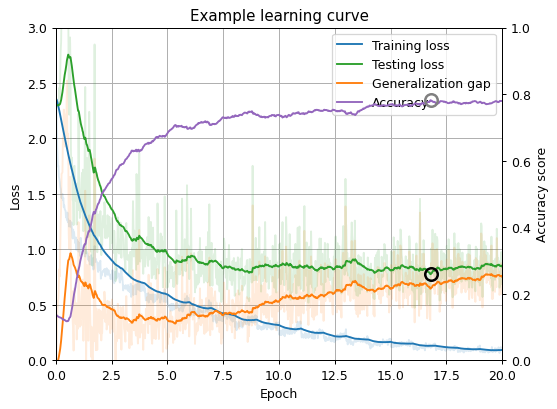

In [58]:
# Example usage

train_set = datasets.CIFAR10(root='data', train=True , download=True, transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, download=True, transform=ToTensor())

model     = NeuralNetwork(dropout_rate=0.1, batch_norm=True).to(device)
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
scheduler = None

metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 20, device)

plot_metrics(metrics, title='Example learning curve')

# Results (instructions) - 55 MARKS <ignore>
Use the Results section to summarise your findings from the experiments. For each experiment, use the Markdown/text cell to describe and explain your results, and use the code cell (and additional code cells if necessary) to conduct the experiment and produce figures to show your results.

### Experiment 1 (17 MARKS) <ignore>

For the highest chosen learning rate ($0.1^{0.8}$), the model is unstable and either does not descend the gradient or halts for a number of epochs before gradient descent takes place.

Between the learning rates $0.1^{0.9}$ and $0.1^{1.1}$, the speed of convergence of the models increases, going from taking $20.3$ epochs to reach minimum test loss to $16.8$ epochs. The time to minimum test loss then increases again for all smaller learning rates. The time to minimum test loss also displays low variation with lower learning rates, for example it falls in the range $[22.7, 27.1]$ for the lowest learning rate ($0.025$) but ranges over $[16.1, 29.3]$ for the highest stable learning rate ($0.126$). Lower learning rates are also stable with regard to training loss, showing fewer spikes.

Although one would expect the accuracy scores for the models to mirror the testing loss, with accuracy getting worse as the model overfits on the training set, surprisingly, the accuracy of all models seems to plateau with increased training, even as the generalization gap grows, indicating that even though the model's predictions become less certain, its best guess about the class of an image is still likely correct.

The learning rate scheduler used for comparison reduces the LR as the testing loss plateaus. The results for this scheduler are significantly worse than the best learning rate ($0.05$), reaching a maximum accuracy of $0.61$, whereas the latter reaches $0.74$ in the average case. It is possible that this is caused by the learning rate being decreased too quickly by the scheduler, leading the model to stop learning too early.

In [3]:
#############################
### Code for Experiment 1 ###
#############################

In [139]:
# Get training and testing data
train_set = datasets.CIFAR10(root='data', train=True , transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, transform=ToTensor())

# Choose learning rates
learning_rates = [0.1**p for p in [0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6]]

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

for learning_rate in learning_rates:

    # Get the number of previous runs with this learning rate
    num_previous_runs = len(results['learning_rate'].get(learning_rate,[]))
    
    # If data for 5 runs of this learning rate already exist, no further data is needed
    if num_previous_runs >= 5: continue

    # Otherwise, create and train models with that learning rate and note their performances
    print(f'Training and testing models with learning rate = {learning_rate}')
    for i in range(num_previous_runs + 1, 6):
        print(f'Run #{i}')
        model     = NeuralNetwork().to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results['learning_rate'][learning_rate] = results['learning_rate'].get(learning_rate,[]) + [metrics]

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

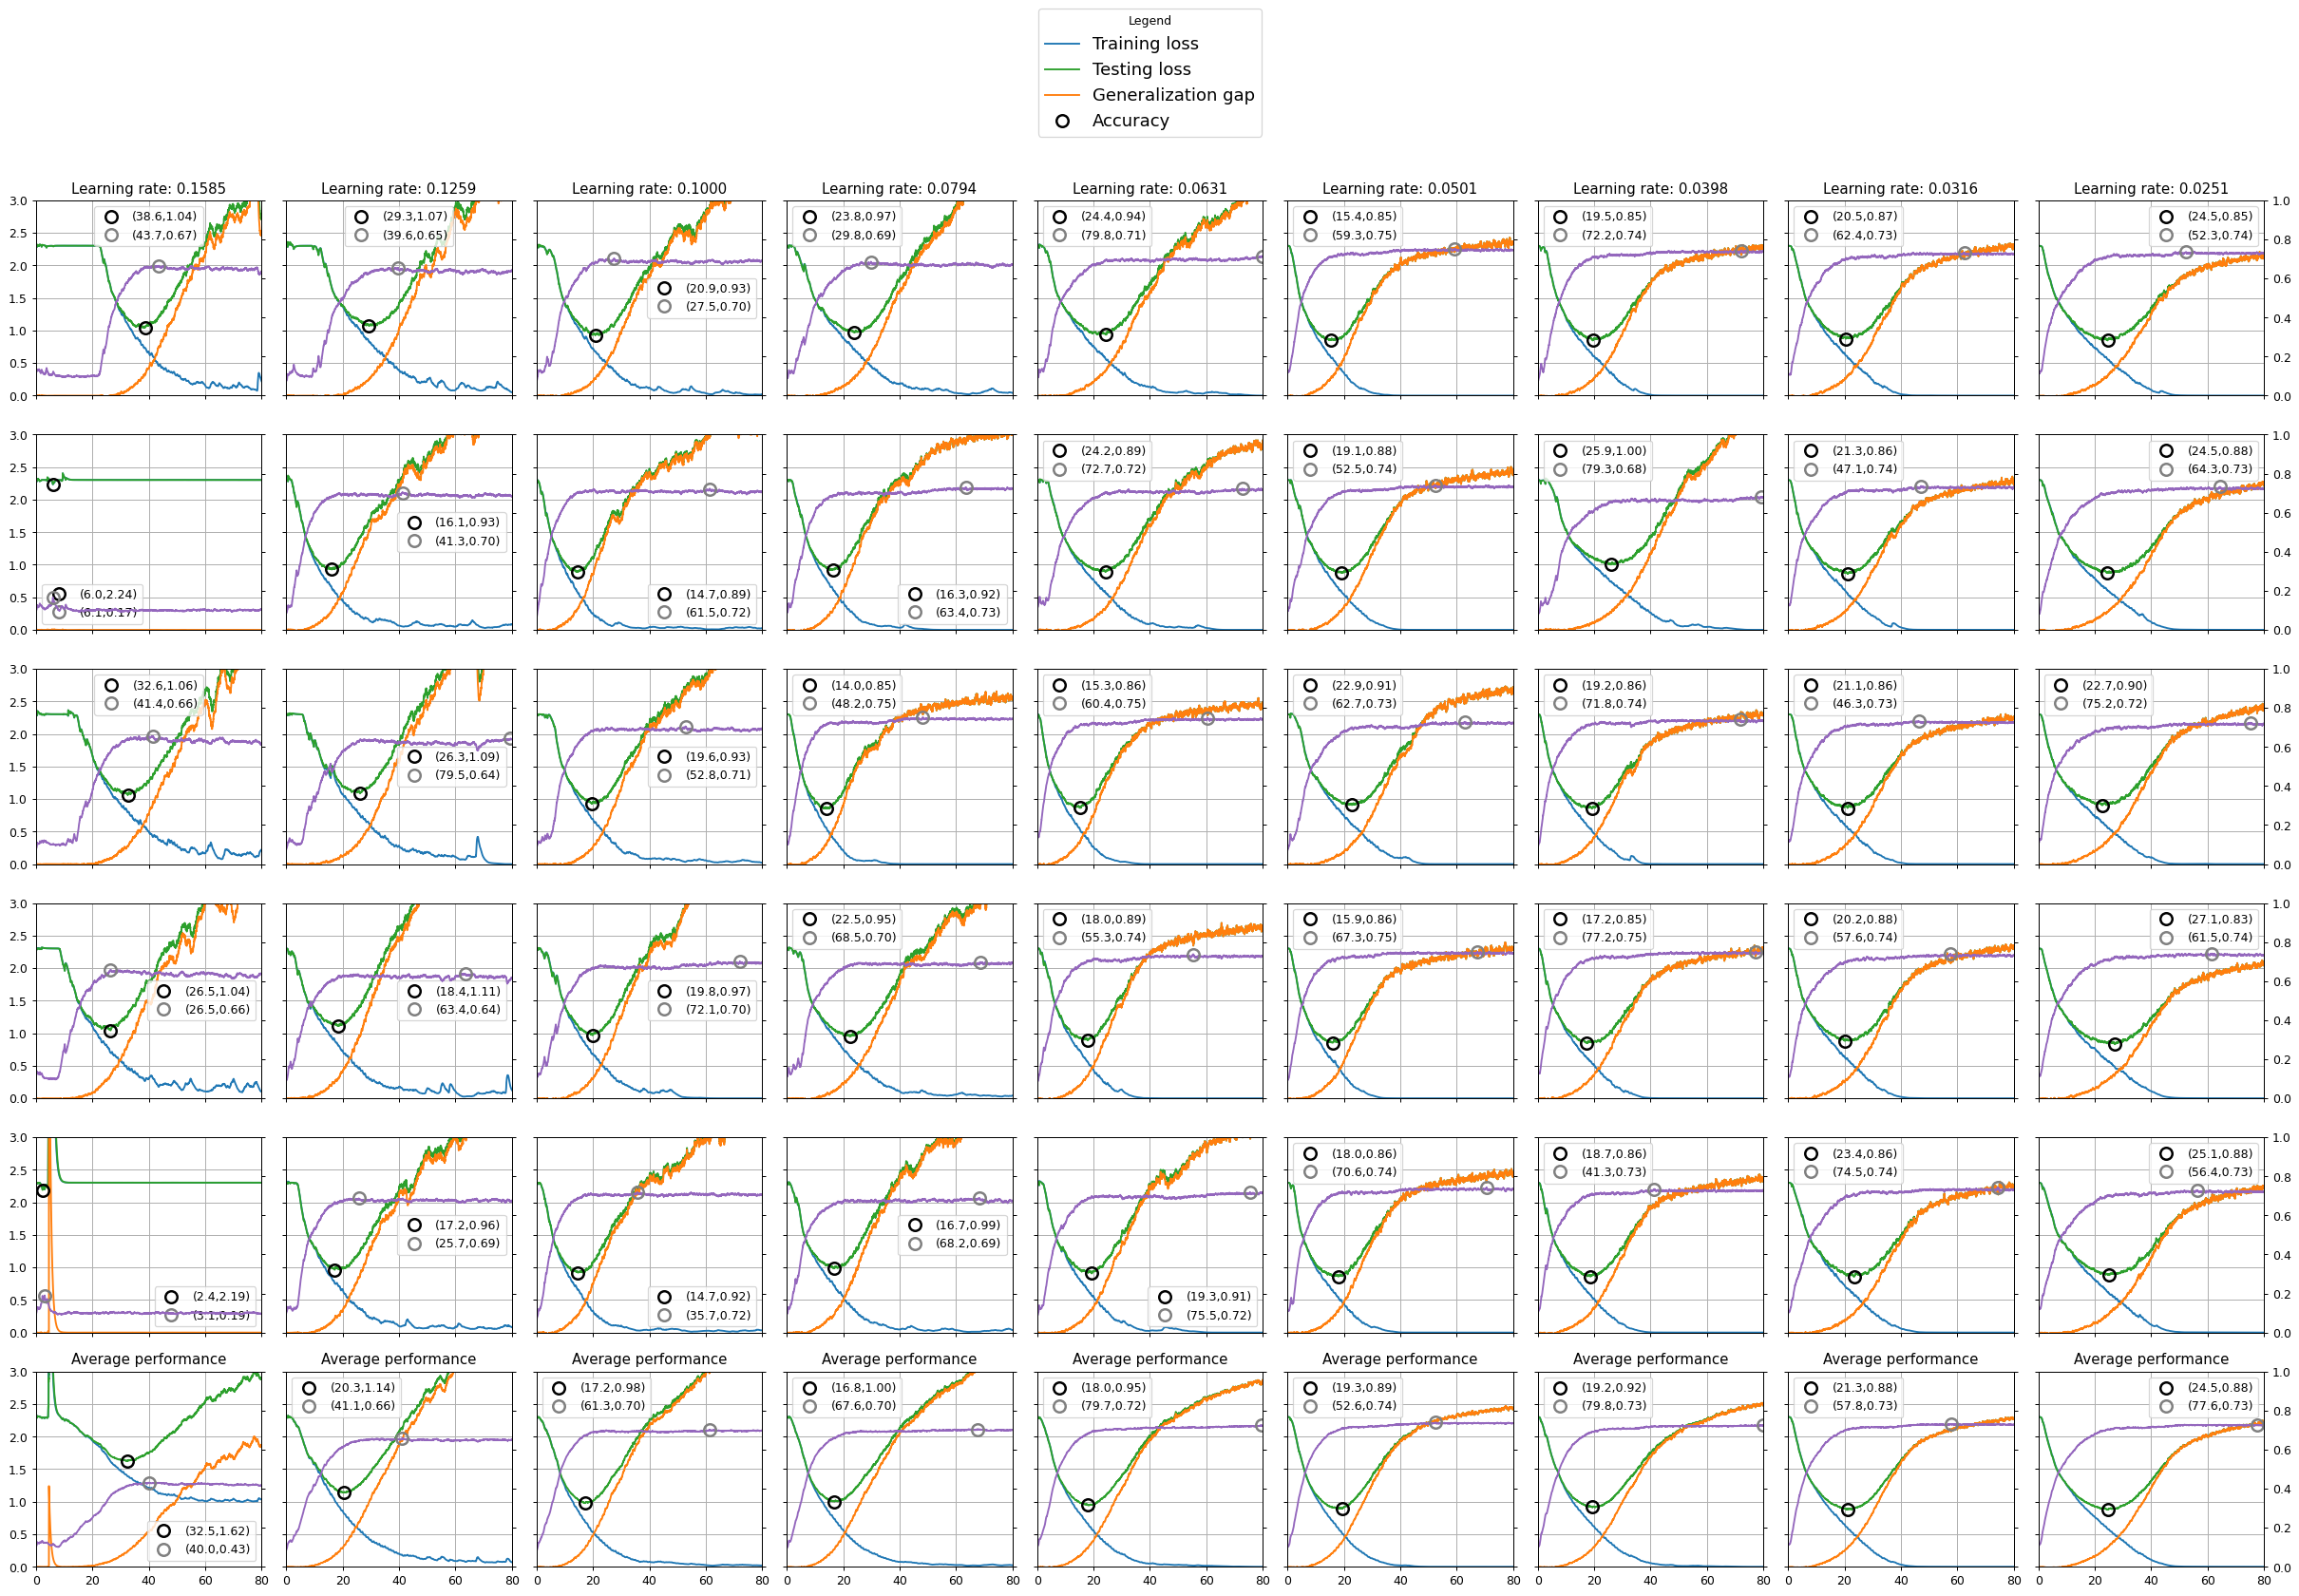

In [77]:
# Plotting results

# Create a 6x9 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=9, figsize=(27,18))

# Iterate over columns and their corresponding learning rates
for col, lr in enumerate(results['learning_rate']):
    
    # Calculate the average performance for that learning rate
    performance_mean = rec_mean(results['learning_rate'][lr])

    # Iterate over the rows in that column and the performance data that
    # corresponds to this run, as well as the average performnce
    for row, data in enumerate(results['learning_rate'][lr][:5]+[performance_mean]):

        # Draw ticks only at the edges
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==8)

        # Draw the subplot for the performance data of this run
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)

        # Only create headings for the top of the column and for the row with the average performance
        if row == 0: axes[row,col].set_title(f'Learning rate: {lr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1.04), fontsize='x-large')

# Show the plot
#fig.text(0.5, 0.01, 'Figure 2. Learning curves for 9 learning rates, showing five test runs\nfor each learning rate as well as average performance', ha='center', va='bottom', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [141]:
# Pick a learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Get the number of previous runs with this scheduler
num_previous_runs = len(results['reduce_lr_on_plateau'])

for i in range(num_previous_runs+1, 6):
    print(f'Run #{i}')
    model     = NeuralNetwork().to(device)
    loss_fn   = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1**0.1, patience=10)
    metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 30, device)
    results['reduce_lr_on_plateau'].append(metrics)

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

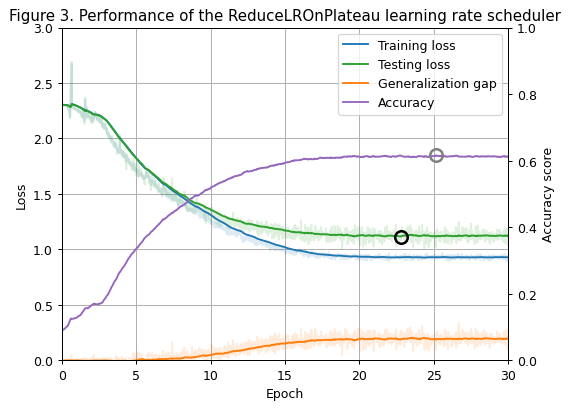

In [63]:
# Plotting the learning curves for the model trained with a scheduler
plot_metrics(rec_mean(results['reduce_lr_on_plateau']), title='Figure 3. Performance of the ReduceLROnPlateau learning rate scheduler')

### Experiment 2 (19 MARKS) <ignore>

Regularization through dropout drastically reduces overfitting, as evidenced by the generalization gaps in the plots below, but this comes at the cost of making the models slower to train, with the time to minimum test loss going gradually from $15.2$ to $37.5$ epochs as the dropout rate grows from $0$ to $0.4$. Accuracy is generally positively affected by higher dropouts, with the model using the highest dropout ($0.4$) having the highest average accuracy ($0.74$).

The best performing zero-dropout and non-zero-dropout models are used for a transfer learning experiment, with their convolutional layers frozen and the fully connected layers' parameters reinitialized. In both cases, giving the model additional training at this point causes it to very quickly (within 5 epochs) reach its maximum accuracy, and both models' accuracy scores are significantly higher than previous models' (scoring $0.77$ and $0.8$ respectively). For the non-zero-dropout model, its performance on the new testing set is significantly better than that for the training set, up until the 10th epoch of training, at which point overfitting starts to take place. This is to be expected, as dropout is inactive during the evaluation run and the the model is able to use its full power, using information from all the features at the same time.

In [2]:
#############################
### Code for Experiment 2 ###
#############################

In [ ]:
# Split data into two halves, one for training and one for validation
torch.manual_seed(0)
train_set = datasets.CIFAR10(root='data', train=True, transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, transform=ToTensor())
train_set, test_set  = random_split(train_set + test_set, [30000, 30000])

# Choose 5 dropout rates
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4]

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Create a container for best performing model at each dropout rate
best_performers = {dr:(-1,None) for dr in dropout_rates}

for dropout_rate in dropout_rates:

    # Get the number of previous runs with this dropout rate
    num_previous_runs = len(results['dropout_rate'].get(dropout_rate,[]))
    
    # If data for 5 runs of this dropout rate already exist, no further data is needed
    if num_previous_runs >= 5: continue
    
    # Otherwise, create and train models with that learning rate and note their performances
    print(f'Training and testing models with dropout rate = {dropout_rate}')
    for i in range(num_previous_runs + 1, 6):
        print(f'Run #{i}')
        model     = NeuralNetwork(dropout_rate = dropout_rate).to(device)
        loss_fn   = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)
        scheduler = None
        metrics   = train_and_test(model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 120, device)
        results['dropout_rate'][dropout_rate] = results['dropout_rate'].get(dropout_rate,[]) + [metrics]

        # Update the best performing model of this dropout rate
        model_last_accuracy = metrics[2][-1]
        best_performers[dropout_rate] = max(best_performers[dropout_rate],
                                            (model_last_accuracy, model))

# Save updated results
with open('results.pickle','wb+') as f:  pickle.dump(results, f)

# Get the best performing model with no dropout, and the one with dropout
_, best_no_dropout_model = best_performers[0.0]
_, best_dropout_model    = max(best_performers[dr] for dr in [0.1, 0.2, 0.3, 0.4])

# Save them for experiment 3
torch.save(best_no_dropout_model, 'best_no_dropout.model')
torch.save(best_dropout_model,    'best_dropout.model')

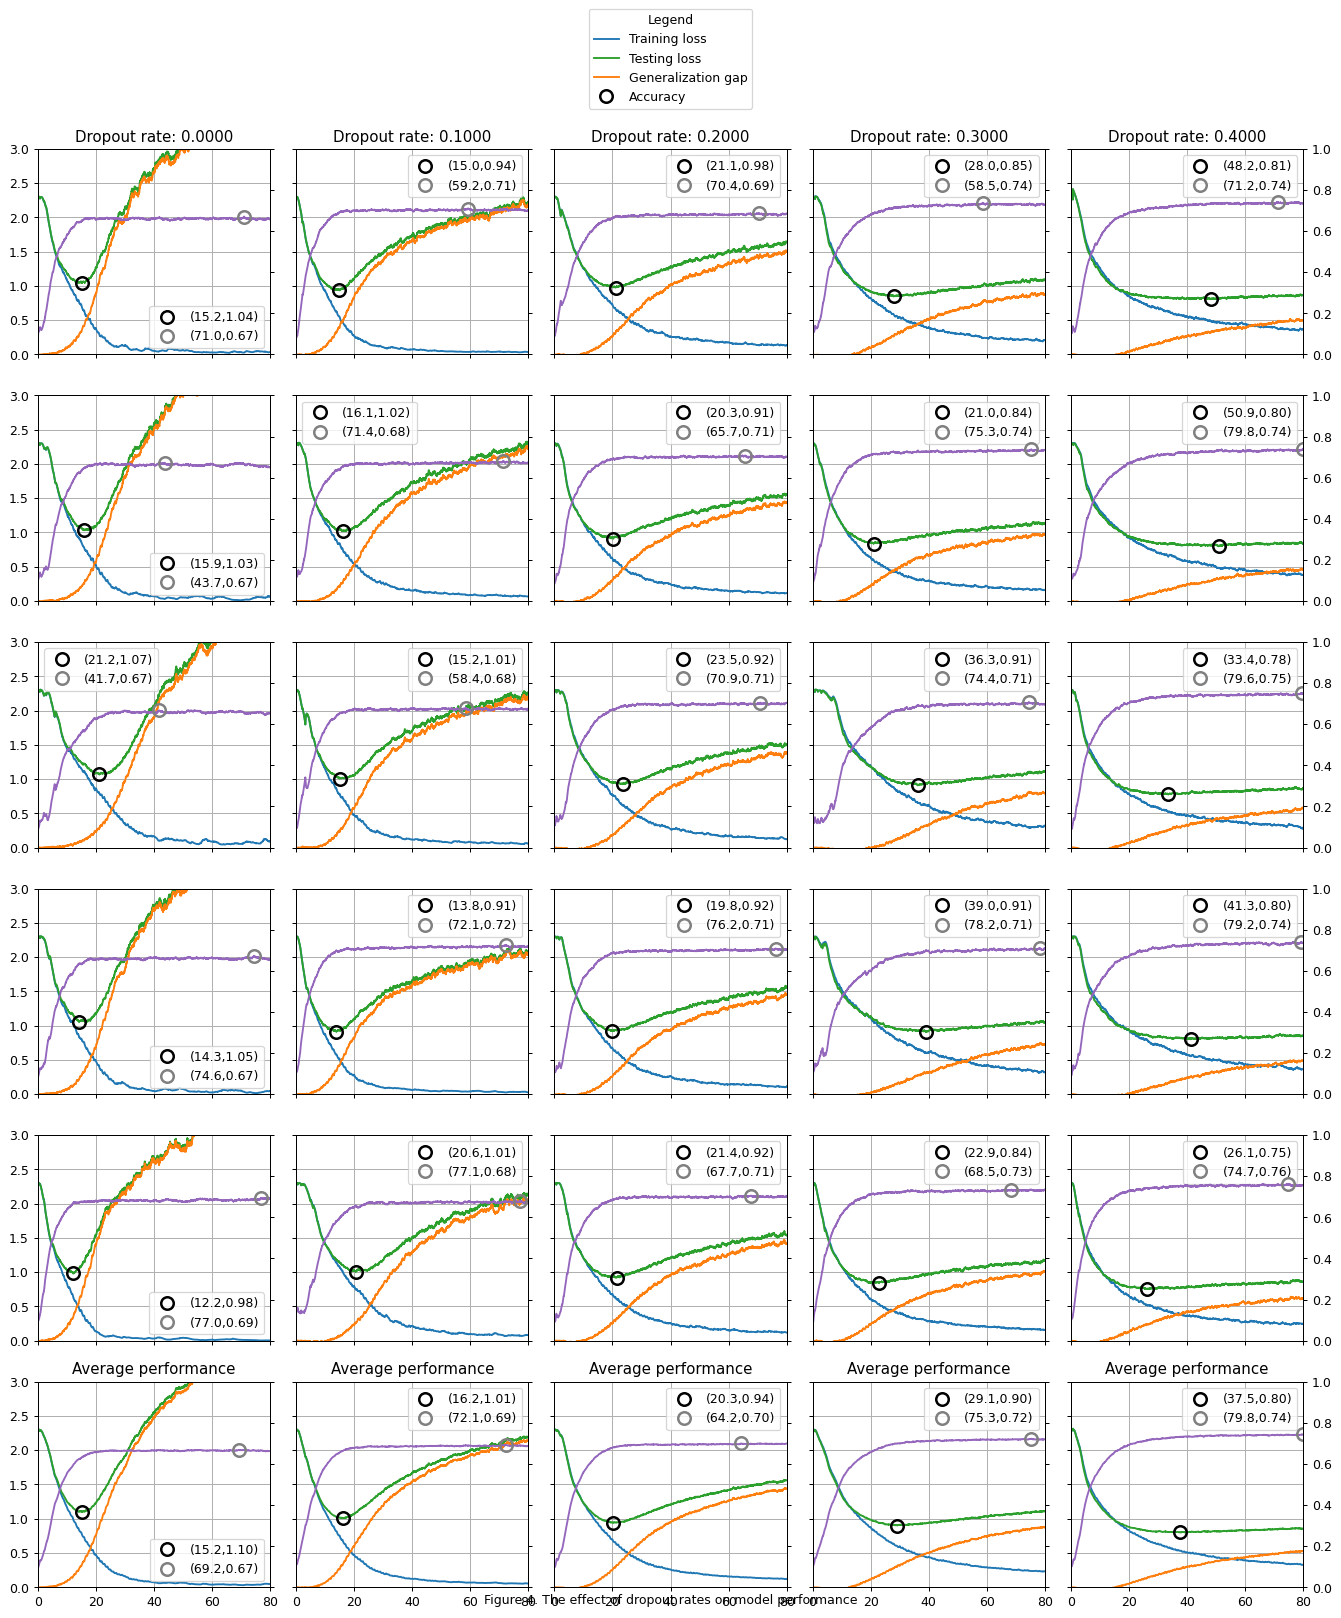

In [75]:
# Plotting results from dropout rate experiment

# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Create a 6x5 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(15,18))

# Iterate over columns and their corresponding dropout rates
for col, dr in enumerate(results['dropout_rate']):
    
    # Calculate the average performance for that dropout rate
    performance_mean = rec_mean(results['dropout_rate'][dr])

    # Iterate over the rows in that column and the performance data that
    # corresponds to this run, as well as the average performnce
    for row, data in enumerate(results['dropout_rate'][dr][:5]+[performance_mean]):

        # Draw ticks only at the edges
        ticks = ('bottom',)*(row==5) + ('left',)*(col==0) + ('right',)*(col==4)

        # Draw the subplot for the performance data of this run
        plot_metrics_to_axes(data, axes[row,col], ticks=ticks, annotate=True, max_epochs=80)

        # Only create headings for the top of the column and for the row with the average performance
        if row == 0: axes[row,col].set_title(f'Dropout rate: {dr:>.4f}')
        if row == 5: axes[row,col].set_title('Average performance')

# Creating a horizontally centered unified legend for the whole figure
fig.legend(['Training loss', 'Testing loss', 'Generalization gap', 'Accuracy'],
           loc='upper center', title='Legend', bbox_to_anchor=(0.5, 1), fontsize='medium')

# Show the plot
#fig.text(0.5, 0.01, 'Figure 4. The effect of dropout rates on model performance', ha='center', va='bottom', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [29]:
# Swap the training and testing sets
train_set, test_set = test_set, train_set

# Get the best performing zero dropout model and the best performing model that uses dropout
best_no_dropout_model = torch.load('best_no_dropout.model')
best_dropout_model    = torch.load('best_dropout.model')

# Make copies of them with new untrained classification heads
no_dropout_model = new_head(best_no_dropout_model)
dropout_model    = new_head(best_dropout_model)

# Train model with no dropout on swapped training set
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(no_dropout_model.parameters(), lr=0.08, momentum=0.9)
scheduler = None
no_dropout_transfer_metrics = train_and_test(no_dropout_model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 20, device)

# Train model with dropout on swapped training set
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dropout_model.parameters(), lr=0.08, momentum=0.9)
scheduler = None
dropout_transfer_metrics = train_and_test(dropout_model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 20, device)

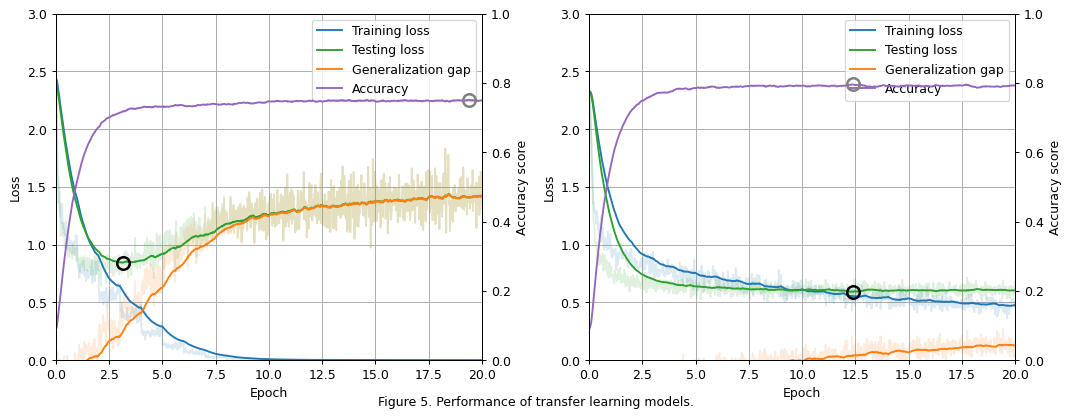

In [74]:
# Plot both models' performances

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

plot_metrics_to_axes(no_dropout_transfer_metrics, axes[0], ticks=('left','bottom','right'), labels=True, legend=True, show_unsmoothed=True, annotate=True)
plot_metrics_to_axes(dropout_transfer_metrics, axes[1], ticks=('left','bottom','right'), labels=True, legend=True, show_unsmoothed=True, annotate=True)

fig.text(0.5, 0.01, 'Figure 5. Performance of transfer learning models.', ha='center', va='bottom', fontsize=10)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### Experiment 3 (19 MARKS) <ignore>

Three models are compared in terms of their learning curves as well as the flow of gradients between them during the training epochs.

The first model does not use dropout or batch normalization, and initially the gradients for all of its parameters are shallow, as parameters are all initialized with similar low values and the gradients are correspondingly small. This can be seen in the first gradient graph, showing that in the first two epochs of training the gradients are uniformly close to zero. As the model begins to learn features of the dataset it quickly bootstraps and the gradients become more varied before it eventually saturates, resting at a low loss with all gradients approaching zero again (see epochs 56-60).

The second model uses dropout. Similarly to the first model, it initially struggles to find a path of descent, as seen on both the gradient plot (initially near-zero gradients) and the learning curve plot (initially flat learning curve). As this model is much slower to reach saturation, gradients are varied even at epochs 116-120.

The third model uses batch normalization. Unlike the first two models, it is able to immediately find a gradient starting from the first epoch of training. This is because batch normalization magnifies the initially small gradients to have a uniform mean and standard deviation before being passed through successive layers of the network, making each layer more responsive to small changes in its inputs. This is also visible in the learning curve plot, where the training loss has a steep slope from the get go. This model converges very quickly, and even at epoch 16 the gradients have already settled at values close to zero, indicating that the model is no longer learning. The accuracy score of this model very quickly climbs to $0.79$.

In [ ]:
#############################
### Code for Experiment 3 ###
#############################

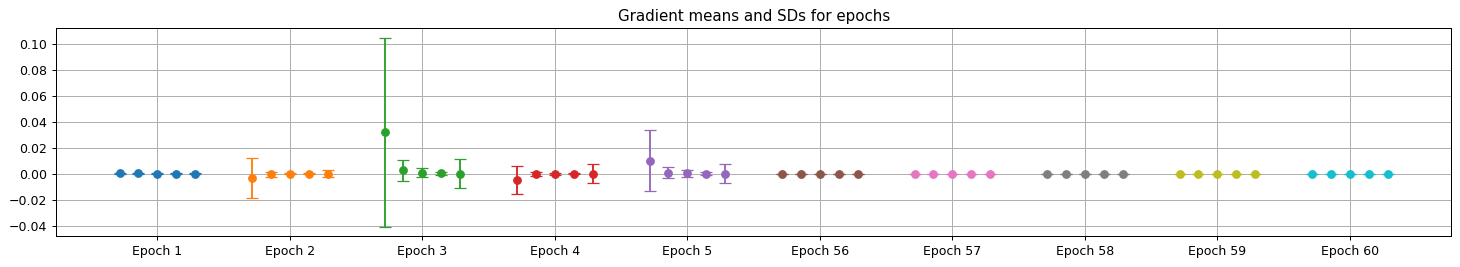

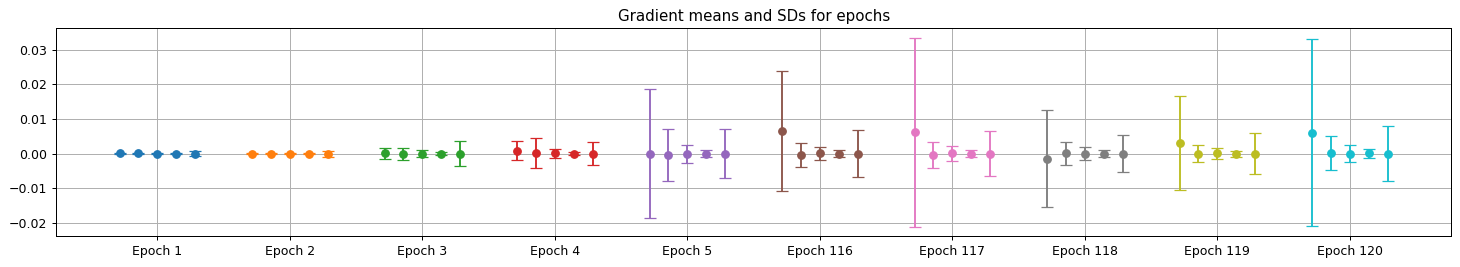

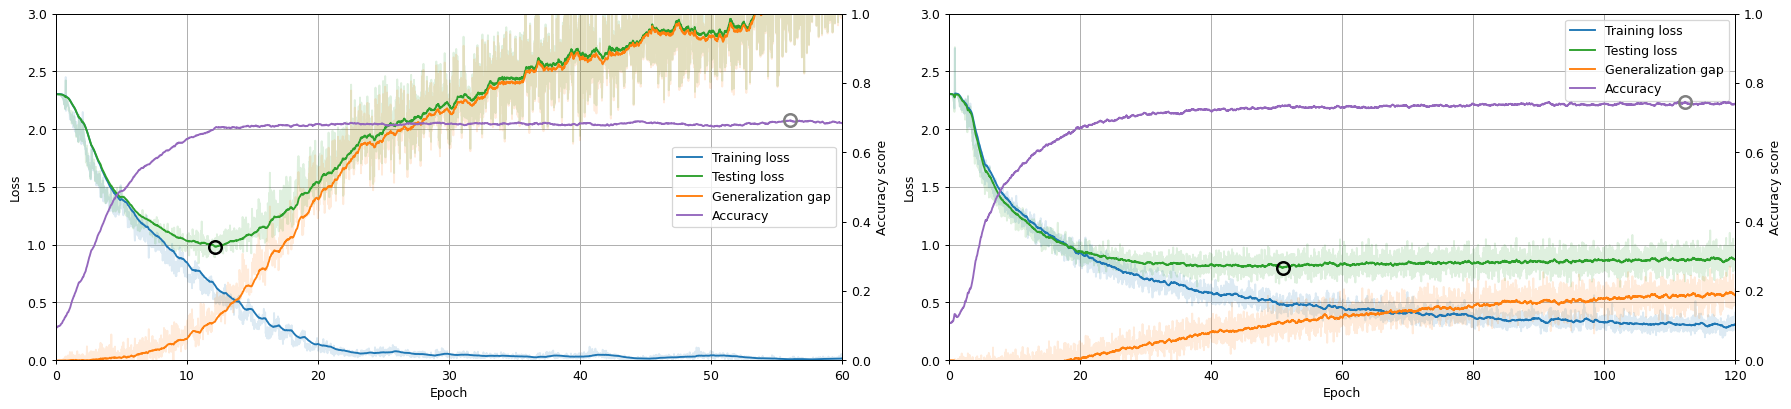

In [53]:
# Load results saved from previous runs
with open('results.pickle','rb+') as f:  results = pickle.load(f)

# Function to get the accuracy of the model at the end of training
def last_accuracy(metrics): return metrics[2][-1]

# Get the metrics for the best performing zero dropout model
best_no_dropout_metrics = max(results['dropout_rate'][0.0], key = last_accuracy)

# Plot its gradient stats
plot_gradient_stats(best_no_dropout_metrics, max_epochs=60)

# Collect all the metrics for models with non-zero dropout
all_dropout_metrics = results['dropout_rate'][0.1] + results['dropout_rate'][0.2] + \
                      results['dropout_rate'][0.3] + results['dropout_rate'][0.4]

# Get the metrics for the best performing non-zero dropout model
best_dropout_metrics = max(all_dropout_metrics, key = last_accuracy)

# Plot its gradient stats
plot_gradient_stats(best_dropout_metrics, max_epochs=120)

# Plot the learning curves for these two models

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plot_metrics_to_axes(best_no_dropout_metrics, axes[0], ticks=('left','bottom','right'), labels=True, legend=True, show_unsmoothed=True, annotate=True, max_epochs=60)
plot_metrics_to_axes(best_dropout_metrics, axes[1], ticks=('left','bottom','right'), labels=True, legend=True, show_unsmoothed=True, annotate=True, max_epochs=120)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [41]:
# Get training and testing data
train_set = datasets.CIFAR10(root='data', train=True , transform=ToTensor())
test_set  = datasets.CIFAR10(root='data', train=False, transform=ToTensor())

# Create a new model that does not use dropout but which uses batch normalization
batch_norm_model = NeuralNetwork(dropout_rate=0.0, batch_norm=True).to(device)

# Train it
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(batch_norm_model.parameters(), lr=0.08, momentum=0.9)
scheduler = None
batch_norm_metrics = train_and_test(batch_norm_model, train_set, test_set, 50, loss_fn, optimizer, scheduler, 20, device)

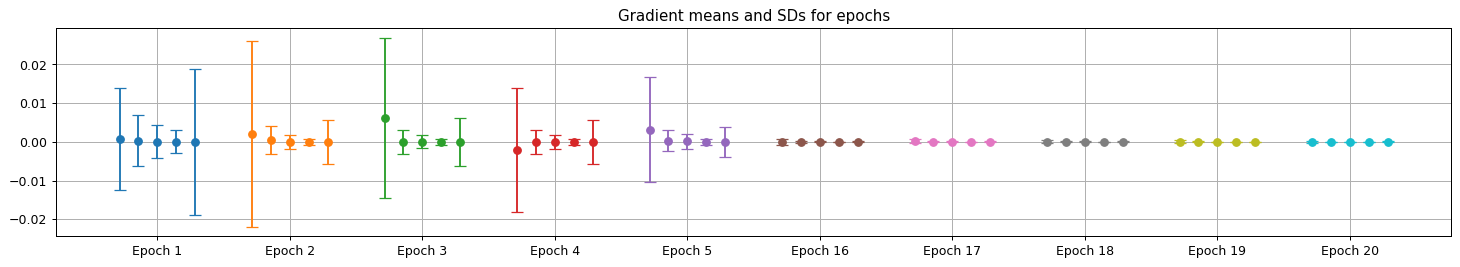

In [48]:
# Plot gradient stats for batch normed model
plot_gradient_stats(batch_norm_metrics)

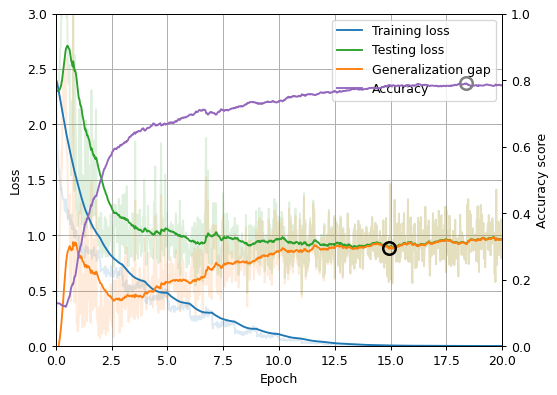

In [43]:
# Plot learning curves for batch normed model
plot_metrics(batch_norm_metrics)

# Conclusions and Discussion (instructions) - 25 MARKS <ignore>
In this section, you are expected to:
* briefly summarise and describe the conclusions from your experiments (8 MARKS).
* discuss whether or not your results are expected, providing scientific reasons (8 MARKS).
* discuss two or more alternative/additional methods that may enhance your model, with scientific reasons (4 MARKS). 
* Reference two or more relevant academic publications that support your discussion. (4 MARKS)

In summary, the learning and dropout rates of a model have significant effects on the speed at which it converges as well as on how well it generalizes to unseen data, with the learning rate having a "sweet spot" between high learning rates which cause it to become unstable and low learning rates which cause it not to saturate. Models with higher dropout rates generally have higher accuracies and smaller generalization gaps but are slower to train. Although the use of a learning rate scheduler should theoretically combine the benefits of both high and low learning rates, ensuring that the model quickly converges but becomes stable, this was hard to implement correctly. Transfer learning was shown to be effective, especially in combination with a model that uses dropout, yielding a 0.8 accuracy. Lastly, contrasting the gradients of a model that uses batch normalization with those that don't shows the value of that technique in making models responsive to shallow gradients.

In all the experiments, an unexpected result was the accuracy score of models on unseen data remaining high even as they were overfitted on their training set and even as their testing loss got larger, although the high testing loss would suggest that the model often gets the classification wrong on unseen data. Another unexpected finding was in experiment 3, where the variance of the gradients across layers seems to consistently decrease across the first four layers in every epoch and to then sharply spike at the last fully connected layer, and my expectation would have been that the lower layers would quickly converge on detecting a set of features and change little afterwards since their inputs (the images) are the most stable. Instead, the layer whose parameters stabilize most quickly is the first fully connected layer.

Various methods could be used to enhance the performance of the models examined. These include image normalization, data augmentation, combining the best learning and dropout rates from this report with batch normalization, using an improved learning scheduler, as well as techniques not examined in this report such as employing fractional max pooling, which has contributed to an accuracy score of 96.5% by (Graham, 2014) and easily available through PyTorch. Lastly, it may be interesting to replace the 10-dimensional classifier head with another head that is trained to identify whether the image portrays a flying object, an animal, a four-legged creature, etc. (information which can be obtained from the existing labels) and then perform transfer learning with the same training set.

# References (instructions) <ignore>
Use the cell below to add your references. A good format to use for references is like this:

[AB Name], [CD Name], [EF Name] ([year]), [Article title], [Journal/Conference Name] [volume], [page numbers] or [article number] or [doi]

Some examples:

JEM Bennett, A Phillipides, T Nowotny (2021), Learning with reinforcement prediction errors in a model of the Drosophila mushroom body, Nat. Comms 12:2569, doi: 10.1038/s41467-021-22592-4

SO Kaba, AK Mondal, Y Zhang, Y Bengio, S Ravanbakhsh (2023), Proc. 40th Int. Conf. Machine Learning, 15546-15566


---

Abouelnaga, Y., Ali, O. S., Rady, H., & Moustafa, M. (2016, December). Cifar-10: Knn-based ensemble of classifiers. In 2016 International Conference on Computational Science and Computational Intelligence (CSCI) (pp. 1192-1195). IEEE.

Krizhevsky, A., & Hinton, G. (2009). Learning multiple layers of features from tiny images.

Martinez, M., & Stiefelhagen, R. (2019). Taming the cross entropy loss. In Pattern Recognition: 40th German Conference, GCPR 2018, Stuttgart, Germany, October 9-12, 2018, Proceedings 40 (pp. 628-637). Springer International Publishing.

Keskar, N. S., & Socher, R. (2017). Improving generalization performance by switching from adam to sgd. arXiv preprint arXiv:1712.07628.

Gupta, A., Ramanath, R., Shi, J., & Keerthi, S. S. (2021, December). Adam vs. sgd: Closing the generalization gap on image classification. In OPT2021: 13th Annual Workshop on Optimization for Machine Learning.

Graham, B. (2014). Fractional max-pooling. arXiv preprint arXiv:1412.6071.

Alom, M. Z., Taha, T. M., Yakopcic, C., Westberg, S., Sidike, P., Nasrin, M. S., ... & Asari, V. K. (2018). The history began from alexnet: A comprehensive survey on deep learning approaches. arXiv preprint arXiv:1803.01164.
